In [1]:
import pandas as pd
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, RepeatVector
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from numpy import abs, array
from math import sqrt

### Get historical data from the NASA POWER PROJECT API
##### Data is collected from: 1st Jan 2012 through 19th March 2022

In [2]:
url = "https://power.larc.nasa.gov/api/temporal/daily/point?start=20120101&end=20220319&latitude=-1.5177&longitude=37.2634&parameters=T2M,PS,WS10M,QV2M,PRECTOTCORR&community=AG&format=csv"

csv_path = keras.utils.get_file(fname="machakos-county-2012-2022.csv", origin=url)

In [3]:
def parse_date(x):
    return datetime.strptime(x, '%Y %j')

In [4]:
# Skip the CSV description rows
df = pd.read_csv(csv_path, skiprows=13, parse_dates={'date': ['YEAR', 'DOY']}, date_parser=parse_date, skipinitialspace=True, index_col=0)

In [5]:
df.head()

,T2M,PS,WS10M,QV2M,PRECTOTCORR
date,,,,,
2012-01-01,19.01,86.89,3.63,7.81,0.00
2012-01-02,19.31,86.83,3.31,7.69,0.00
2012-01-03,20.82,86.77,2.73,9.16,0.00
2012-01-04,21.26,86.70,2.77,9.70,0.00
2012-01-05,21.69,86.77,2.80,9.89,0.25


In [6]:
# Get column names
df.columns

Index(['T2M', 'PS', 'WS10M', 'QV2M', 'PRECTOTCORR'], dtype='object')

In [7]:
# Remove empty values
indexes_to_drop = df.index[df['T2M'] == -999.00]
df.drop(indexes_to_drop, inplace=True)

<AxesSubplot:xlabel='PRECTOTCORR'>

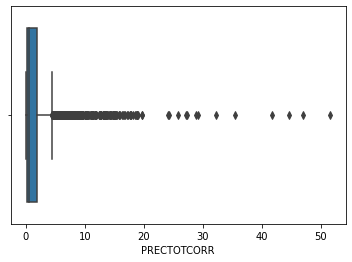

In [8]:
# Check for outliers
sns.boxplot(x=df['PRECTOTCORR'])

In [9]:
from scipy import stats
z = abs(stats.zscore(df))

df_without_outliers = df[(z < 3).all(axis=1)]

print(df.shape)
print(df_without_outliers.shape)

(3729, 5)
(3617, 5)


<AxesSubplot:>

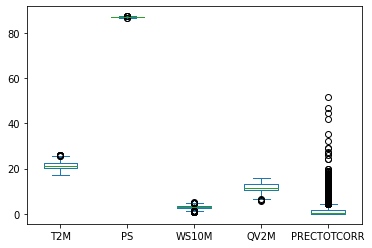

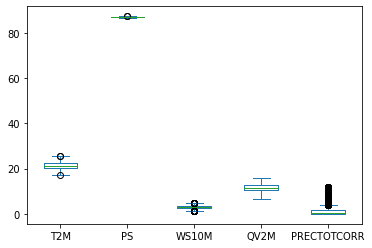

In [10]:
# Box plot
df.plot.box()
df_without_outliers.plot.box()

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

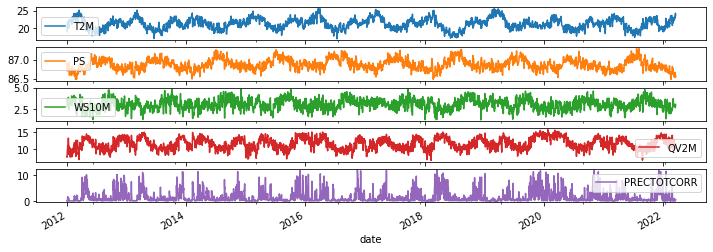

In [11]:
# Visualize trends
df_without_outliers.plot.line(figsize=(12, 4), subplots=True)
# plt.savefig("Sub plot", dpi=1200)

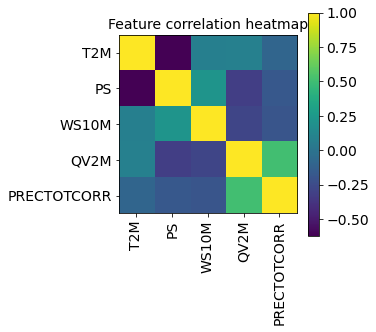

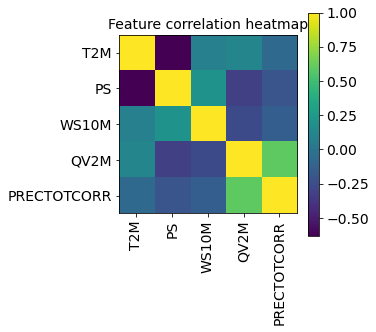

In [12]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature correlation heatmap", fontsize=14)
    plt.show()

show_heatmap(df)
show_heatmap(df_without_outliers)

In [13]:
correlation = df_without_outliers.corr()
print(correlation['PRECTOTCORR'].sort_values(ascending = False),'\n')

PRECTOTCORR    1.000000
QV2M           0.594752
T2M           -0.074322
WS10M         -0.142011
PS            -0.197509
Name: PRECTOTCORR, dtype: float64 



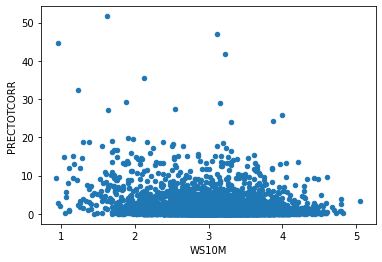

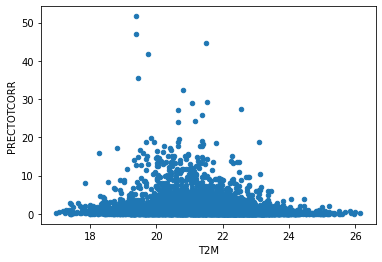

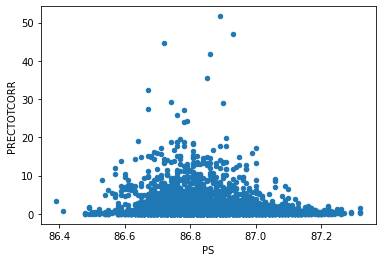

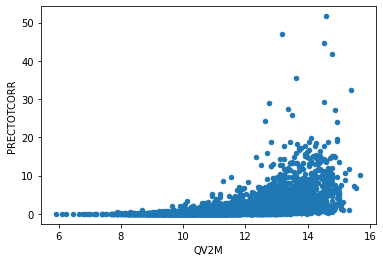

In [14]:
for i in ['WS10M', 'T2M', 'PS', 'QV2M']:
    df.plot.scatter(x=i, y='PRECTOTCORR')

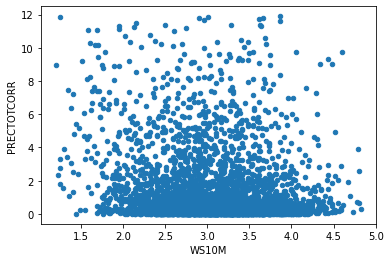

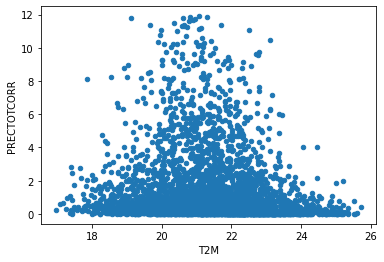

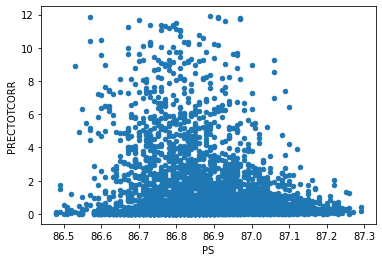

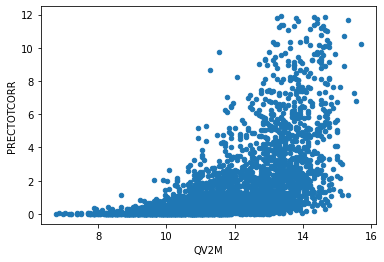

In [15]:
for i in ['WS10M', 'T2M', 'PS', 'QV2M']:
    df_without_outliers.plot.scatter(x=i, y='PRECTOTCORR')

In [16]:
# Drop PS columns as it is multicorrelated to the T2M column
df_without_outliers = df_without_outliers.drop(['PS'], axis=1)

In [17]:
# split multivariate sequence into samples
def to_supervised(sequences, n_steps_back, n_steps_future):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of the pattern
        end_index = i + n_steps_back
        out_end_index = end_index + n_steps_future - 1
        # check if index is out of bound
        if out_end_index > len(sequences) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_index, :-1], sequences[end_index-1:out_end_index, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [18]:
# Normalization
scaler = MinMaxScaler(feature_range=(0,1))

df_scaled = scaler.fit_transform(df_without_outliers)

scaler.n_features_in_

4

In [19]:
X, y = to_supervised(df_scaled,n_steps_back=28,n_steps_future=7)

In [20]:
print('Y shape', y.shape)
print('X shape', X.shape)
print('DF Scaled', df_scaled.shape)

Y shape (3583, 7)
X shape (3583, 28, 3)
DF Scaled (3617, 4)


In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Problem Framing
#### Given the past 28 days historical weather data, forecast the rainfall for the next 7 days

In [22]:
model = Sequential()
# model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
# model.add(LSTM(32, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(y_train.shape[1]))
model.add(LSTM(200, activation='relu', input_shape=(28, 3)))
model.add(RepeatVector(7))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')

# model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               163200    
                                                                 
 repeat_vector (RepeatVector  (None, 7, 200)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 7, 200)            320800    
                                                                 
 time_distributed (TimeDistr  (None, 7, 100)           20100     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 7, 1)             101       
 tributed)                                                       
                                                        

In [23]:
history = model.fit(x_train, y_train, epochs=50, batch_size=28, validation_split=0.33, verbose=1)

Epoch 1/50
58/58 [==============================] - 6s 56ms/step - loss: 0.0318 - val_loss: 0.0286
Epoch 2/50
58/58 [==============================] - 3s 47ms/step - loss: 0.0291 - val_loss: 0.0292
Epoch 3/50
58/58 [==============================] - 3s 46ms/step - loss: 0.0286 - val_loss: 0.0263
Epoch 4/50
58/58 [==============================] - 3s 48ms/step - loss: 0.0271 - val_loss: 0.0258
Epoch 5/50
58/58 [==============================] - 3s 50ms/step - loss: 0.0267 - val_loss: 0.0264
Epoch 6/50
58/58 [==============================] - 3s 49ms/step - loss: 0.0269 - val_loss: 0.0254
Epoch 7/50
58/58 [==============================] - 3s 50ms/step - loss: 0.0263 - val_loss: 0.0251
Epoch 8/50
58/58 [==============================] - 3s 51ms/step - loss: 0.0264 - val_loss: 0.0255
Epoch 9/50
58/58 [==============================] - 3s 52ms/step - loss: 0.0260 - val_loss: 0.0257
Epoch 10/50
58/58 [==============================] - 3s 50ms/step - loss: 0.0262 - val_loss: 0.0251
Epoch 11/

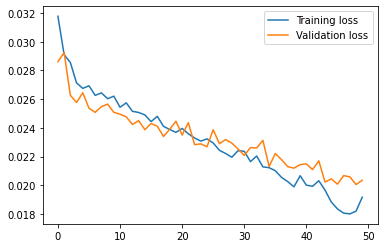

In [24]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [25]:
y_pred = model.predict(x_test, verbose=0)

In [26]:
from numpy import zeros


In [27]:
def reverse_y_scaler(data):
    data = data.ravel() # convert from 2D array into 1D array
    # create a new numpy array
    shape = (data.shape[0], 4)
    n_array = zeros(shape)
    n_array[:, -1] = data
    return n_array

In [28]:
# Does the scaler work in reverse
inv_yhat = scaler.inverse_transform(reverse_y_scaler(y_pred))[:, -1]
inv_ytest = scaler.inverse_transform(reverse_y_scaler(y_test))[:, -1]

## Evaluation Metric
Evaluate each time step separately in order to:
* Comment on the skill at a particular lead time (1 day vs 3 day)
* Contrast models based on their skills at different lead times (models good at +1 day vs models good at days +5)

Adopt an error metric that has the metric in (mm) similar to our target variable, rainfall.
Use Root Mean Square Error (RMSE), it has a higher punishment on forecast errors.

In [29]:
from numpy import sum
def mse_loss(y_pred, y_true):
    squared_error = (y_pred - y_true) ** 2
    sum_squared_error = sum(squared_error)
    loss = sum_squared_error / y_true.size
    return loss

In [30]:
mse = mse_loss(inv_yhat, inv_ytest)
print('Mean Squared Error', mse)

Mean Squared Error 3.038020653485344


In [31]:
root_mean_square = sqrt(mse)
print(root_mean_square)

1.7429918684507235


In [32]:
# Use on new data
def scale_X_input(data):
    # covert the input shape from 
    # [timesteps, n_features] to [samples, timesteps, n_features]
    return data.reshape((1, data.shape[0], data.shape[1]))

    

In [33]:
test_input = scale_X_input(X[0])

In [34]:
scaler.inverse_transform(reverse_y_scaler(model.predict(test_input)))[:,-1]

array([0.14111073, 0.22304929, 0.33108436, 0.37273072, 0.40149544,
       0.42534301, 0.44201677])

In [35]:
model.save('rainfall-model')

INFO:tensorflow:Assets written to: rainfall-model\assets
